# ALgoritmo de aprendisaje automático para diseño de conexiones precalificadas

## Importación de librerías

Las librerías empleadas para el funcionamiento del algoritmo son 
- Numpy: Librería que contiene herramientas para manipulación de variables multidimensionales.
- Pandas: Librería para gestionar datos tabulados en multiples formatos.
- Matplotlib: Librería para generar gráficas.
- Seaborn: Librería que contiene herramientas para generar gráficas estadísticas profesionales
- sickit-learn: Librería que contiene algoritmos de aprendisaje automático
- jolib: Para guardar los modelos de entrenamiento.

In [64]:
import os  # Importado para manejar archivos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from StructuralDesign import StructuralDesign
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score 
import joblib 

## Generación de datos de entrenamiento

Los datos de entrenamiento se generan automaticamente de forma aleaotoria empleando datos de entrada correspondientes a los parámetros del diseño.
Estos parámetros de diseño son procesados meditante algoritmos que automatizan el proceso de diseño mediante los objetos anidados en la clase "StructuralDesign".
Las variables correspondientes a los resultados del diseño son entonces ordenadas en columnas dentro del conjunto de los datos de entrenamiento tabulados.

In [65]:
def generate_dataset(connection_type, N=1000, csv_file='dataset.csv'):
    # Define shared ranges
    shared_ranges = {
        'A_sec': [36, 50],
        'A_trab': [36, 50],
        'fc': [210, 280],
        'L1': [4.0, 8.0],
        'L2': [4.0, 8.0],
        'Pisos': [1, 4],
        'Cm': [0.3, 0.7],
        'Cv': [0.15, 0.35],
        'vigas_sec_bf': [10, 20],
        'vigas_sec_tf': [0.4, 1.2],
        'vigas_sec_h': [20, 50],
        'vigas_sec_tw': [0.25, 0.8],
        'vigas_trab_bf': [12, 25],
        'vigas_trab_tf': [0.6, 1.6],
        'vigas_trab_h': [30, 60],
        'vigas_trab_tw': [0.4, 1.0],
        'col_b': [25, 40],
        'col_h': [25, 40],
        'col_e': [0.3, 0.8],
    }

    # Define specific ranges per connection type
    connection_ranges = {
        'RBS': {
            'rbs_a': [6, 12],
            'rbs_b': [20, 35],
            'rbs_c': [2.0, 5.0],
            'rbs_tp': [0.6, 1.5]
        },
        'EndPlate4E': {
            'ep4e_tp': [1.5, 3.5],
            'ep4e_bp': [15, 30],
            'ep4e_g': [10, 20],
            'ep4e_pf': [3, 6],
            'ep4e_perno': [0.75, 1.25]
        },
        'WUF': {
            'wuf_E': [60, 100],
            'wuf_tp': [0.5, 1.0],
            'wuf_a': [0.5, 1.0],
            'wuf_Acero': [36, 50]
        }
    }

    if connection_type not in connection_ranges:
        raise ValueError(f"Unsupported connection type: {connection_type}. Supported: {list(connection_ranges.keys())}")

    specific_ranges = connection_ranges[connection_type]

    # Define output keys per connection type based on provided dictionaries
    output_keys = {
        'RBS': {
            'Resultados_RBS': ['sh', 'Mpr_viga', 'Zrbs', 'Mpr_con', 'Vu', 'Vn', 'Mf', 'Mpe']
        },
        'EndPlate4E': {
            'Resultados': ['Mpr', 'Sh', 'Vu', 'Mf', 'Esfv', 'Efst', 'Estreal', 'tp_min'],
            'Refuerzo Adicional': ['Zp', 'g']
        },
        'WUF': {
            'Calculos_conexion': ['Mpr', 'Vh'],
            'Placa-Alma': ['Vu', 'Rs']
        }
    }

    # Create expected output keys with side suffix (iz, der)
    expected_output_keys = []
    for section, keys in output_keys[connection_type].items():
        for key in keys:
            expected_output_keys.append(f"{section}_{key}_iz")
            expected_output_keys.append(f"{section}_{key}_der")

    # Fixed parametros_conexiones
    parametros_conexiones = {
        'iz': {
            'angulo_apernado': {'Perno': 3/8, 'hp': 15, 'Lbord': 3, 'bp': 6},
            'angulo_soldado': {'E': 60, 'g': 0.3, 'hp': 15, 'tp': 0.3, 'bp': 6},
            'asiento_apernado': {'Perno': 3/8, 'bp': 6},
            'asiento_soldado': {'E': 60, 'bp': 5, 'tp': 0.3},
            'alma_alma': {'E': 60, 'hs': 15, 'g': 0.3}
        },
        'der': {
            'angulo_apernado': {'Perno': 3/8, 'hp': 15, 'Lbord': 3, 'bp': 6},
            'angulo_soldado': {'E': 60, 'g': 0.3, 'hp': 15, 'tp': 0.3, 'bp': 6},
            'asiento_apernado': {'Perno': 1/2, 'bp': 6},
            'asiento_soldado': {'E': 60, 'bp': 5, 'tp': 0.4},
            'alma_alma': {'E': 60, 'hs': 16, 'g': 0.3}
        }
    }

    # Fixed Atiesadores
    atiesadores = {
        'Sentido_b': {'Num': 1, 'I': 4, 'e': 0.3},
        'Sentido_h': {'Num': 1, 'I': 4, 'e': 0.3}
    }

    # Determine calculate function and results attribute
    if connection_type == 'RBS':
        calculate_fn = lambda sd, lado: sd.calculate_rbs_connection(lado)
        results_attr = 'resultados_RBS'
    elif connection_type == 'EndPlate4E':
        calculate_fn = lambda sd, lado: sd.calculate_end_plate_4e_connection(lado)
        results_attr = 'resultados_end_plate_4E'
    elif connection_type == 'WUF':
        calculate_fn = lambda sd, lado: sd.calculate_wuf_w_connection(lado)
        results_attr = 'resultados_WUF_W'

    rows = []
    for _ in range(N):
        while True:
            # Sample shared parameters
            shared_samples = {}
            for key, (low, high) in shared_ranges.items():
                if key == 'Pisos':
                    shared_samples[key] = np.random.randint(low, high + 1)
                elif key in ['A_sec', 'A_trab', 'fc']:
                    shared_samples[key] = np.random.choice([low, high])
                else:
                    shared_samples[key] = np.random.uniform(low, high)

            # Sample specific parameters
            specific_samples = {}
            for key, (low, high) in specific_ranges.items():
                specific_samples[key] = np.random.uniform(low, high)

            # Extract for readability
            A_sec = shared_samples['A_sec']
            A_trab = shared_samples['A_trab']
            fc = shared_samples['fc']
            L1 = shared_samples['L1']
            L2 = shared_samples['L2']
            Pisos = shared_samples['Pisos']
            Cm = shared_samples['Cm']
            Cv = shared_samples['Cv']
            vigas_sec_bf = shared_samples['vigas_sec_bf']
            vigas_sec_tf = shared_samples['vigas_sec_tf']
            vigas_sec_h = shared_samples['vigas_sec_h']
            vigas_sec_tw = shared_samples['vigas_sec_tw']
            vigas_trab_bf = shared_samples['vigas_trab_bf']
            vigas_trab_tf = shared_samples['vigas_trab_tf']
            vigas_trab_h = shared_samples['vigas_trab_h']
            vigas_trab_tw = shared_samples['vigas_trab_tw']
            col_b = shared_samples['col_b']
            col_h = shared_samples['col_h']
            col_e = shared_samples['col_e']

            # Basic structural validations
            valid = True
            if not (vigas_sec_h > 2 * vigas_sec_tf and vigas_sec_h / vigas_sec_tw < 100 and vigas_sec_bf / (2 * vigas_sec_tf) < 10):
                valid = False
            if not (vigas_trab_h > 2 * vigas_trab_tf and vigas_trab_h / vigas_trab_tw < 100 and vigas_trab_bf / (2 * vigas_trab_tf) < 10):
                valid = False
            if not (col_h > 2 * col_e and col_b > 2 * col_e):
                valid = False

            if valid:
                break

        # Build input dictionaries
        materiales = {
            'A_sec': A_sec,
            'A_trab': A_trab,
            'E': 2100000,
            'fc': fc
        }

        datos_arquitectonicos = {
            'L1': L1,
            'L2': L2,
            'L3': L1,
            'L4': L2,
            'Pisos': Pisos,
            'Cm': Cm,
            'Cv': Cv,
            'He': 3,
            'Cu': 1.2 * Cm + 1.6 * Cv
        }

        num_vigas = np.random.randint(2, 6)

        propiedades_vigas = {
            'vigas_sec_prop': {
                'iz': {'Acero': A_sec, 'bf': vigas_sec_bf, 'tf': vigas_sec_tf, 'h': vigas_sec_h, 'tw': vigas_sec_tw},
                'der': {'Acero': A_sec, 'bf': vigas_sec_bf, 'tf': vigas_sec_tf, 'h': vigas_sec_h, 'tw': vigas_sec_tw}
            },
            'vigas_trab_prop': {
                'iz': {'Acero': A_trab, 'bf': vigas_trab_bf, 'tf': vigas_trab_tf, 'h': vigas_trab_h, 'tw': vigas_trab_tw},
                'der': {'Acero': A_trab, 'bf': vigas_trab_bf, 'tf': vigas_trab_tf, 'h': vigas_trab_h, 'tw': vigas_trab_tw}
            },
            'vigas_secundarias': {
                'iz': {'Acero': A_sec, 'Lv': L2, 'Lt': L1, 'Vigas': num_vigas},
                'der': {'Acero': A_sec, 'Lv': L2, 'Lt': L1, 'Vigas': num_vigas}
            },
            'vigas_trab': {
                'iz': {'Acero': A_trab, 'Tipo': 'Central', 'Lv': L2, 'Lt': L1, 'Num': num_vigas},
                'der': {'Acero': A_trab, 'Tipo': 'Central', 'Lv': L2, 'Lt': L1, 'Num': num_vigas}
            }
        }

        propiedades_columna = {
            'columna': {'Acero': 50, 'Relleno hormigon': 'SI', 'b': col_b, 'h': col_h, 'e': col_e},
            'Atiesadores': atiesadores
        }

        propiedades_conexiones = {
            'Prop_RBS': {
                'iz': {'a': 8, 'b': 28, 'c': 3.6, 'E_pat': 80, 'tp': 1, 'hh': 1.2, 'bp': 5, 'E_alma': 60},
                'der': {'a': 8, 'b': 28, 'c': 3.6, 'E_pat': 80, 'tp': 1, 'hh': 1.2, 'bp': 5, 'E_alma': 60}
            },
            'Prop_end_plate_4E': {
                'iz': {'Acero': 50, 'Tipo': 'A490', 'Perno': 1, 'tp': 2.5, 'bp': 20, 'g': 15.2, 'pf': 4, 'E': 80},
                'der': {'Acero': 50, 'Tipo': 'A490', 'Perno': 1, 'tp': 2.5, 'bp': 20, 'g': 15.2, 'pf': 4, 'E': 80}
            },
            'Prop_end_plate_4ES': {
                'iz': {'Acero_ep': 50, 'Tipo': 'A490', 'Perno': 1, 'tp': 2.5, 'bp': 20, 'g': 15.2, 'pf': 4.4, 'de': 4.4, 'E': 80},
                'der': {'Acero_ep': 50, 'Tipo': 'A490', 'Perno': 1, 'tp': 2.5, 'bp': 20, 'g': 15.2, 'pf': 4, 'de': 4.4, 'E': 80}
            },
            'Diafragma_externo': {
                'iz': {'Ln': 30, 'td': 1.2, 'Acero_de': 50, 'E_patin_diaf': 60},
                'der': {'Ln': 32, 'td': 1.2, 'Acero_de': 50, 'E_patin_diaf': 60}
            },
            'Prop_WUF_W': {
                'iz': {'E': 100, 'tp': 0.6, 'a': 0.6, 'Acero': 36},
                'der': {'E': 100, 'tp': 0.6, 'a': 0.6, 'Acero': 36}
            }
        }

        if connection_type == 'RBS':
            for lado in ['iz', 'der']:
                propiedades_conexiones['Prop_RBS'][lado]['a'] = specific_samples['rbs_a']
                propiedades_conexiones['Prop_RBS'][lado]['b'] = specific_samples['rbs_b']
                propiedades_conexiones['Prop_RBS'][lado]['c'] = specific_samples['rbs_c']
                propiedades_conexiones['Prop_RBS'][lado]['tp'] = specific_samples['rbs_tp']
        elif connection_type == 'EndPlate4E':
            for lado in ['iz', 'der']:
                propiedades_conexiones['Prop_end_plate_4E'][lado]['tp'] = specific_samples['ep4e_tp']
                propiedades_conexiones['Prop_end_plate_4E'][lado]['bp'] = specific_samples['ep4e_bp']
                propiedades_conexiones['Prop_end_plate_4E'][lado]['g'] = specific_samples['ep4e_g']
                propiedades_conexiones['Prop_end_plate_4E'][lado]['pf'] = specific_samples['ep4e_pf']
                propiedades_conexiones['Prop_end_plate_4E'][lado]['Perno'] = specific_samples['ep4e_perno']
        elif connection_type == 'WUF':
            for lado in ['iz', 'der']:
                propiedades_conexiones['Prop_WUF_W'][lado]['E'] = specific_samples['wuf_E']
                propiedades_conexiones['Prop_WUF_W'][lado]['tp'] = specific_samples['wuf_tp']
                propiedades_conexiones['Prop_WUF_W'][lado]['a'] = specific_samples['wuf_a']
                propiedades_conexiones['Prop_WUF_W'][lado]['Acero'] = specific_samples['wuf_Acero']

        # Instantiate and calculate
        outputs = {key: np.nan for key in expected_output_keys}
        try:
            sd = StructuralDesign(
                materiales,
                datos_arquitectonicos,
                propiedades_vigas,
                propiedades_columna,
                propiedades_conexiones,
                parametros_conexiones
            )
            sd._calcular_propiedades_iniciales()
            # Calculate for both sides
            for lado in ['iz', 'der']:
                results = calculate_fn(sd, lado)
                for section, keys in output_keys[connection_type].items():
                    for key in keys:
                        output_key = f"{section}_{key}_{lado}"
                        result_dict = results.get(section, {}).get('valores', {})
                        value = result_dict.get(key, np.nan)
                        outputs[output_key] = round(value, 3) if isinstance(value, (int, float)) and not np.isnan(value) else np.nan
        except Exception as e:
            pass  # Outputs remain NaN

        # Combine into row
        row = {**shared_samples, **specific_samples, **outputs}
        rows.append(row)

    # Create DataFrame and export
    df = pd.DataFrame(rows)
    df.to_csv(csv_file, index=False)
    print(f"Dataset generated and saved to {csv_file}")

# Example usage:
n = 100
generate_dataset('RBS', N=n, csv_file='dataset_RBS.csv')
generate_dataset('EndPlate4E', N=n, csv_file='dataset_EndPlate4E.csv')
generate_dataset('WUF', N=n, csv_file='dataset_WUF.csv')

Dataset generated and saved to dataset_RBS.csv
Dataset generated and saved to dataset_EndPlate4E.csv
Dataset generated and saved to dataset_WUF.csv


## Entrenamiento de bosque de regresion

El proceso de entrenamiento del algoritmo emplea un bosque de regresión para cada una de las variables de salida generadas por eln algoritmo de diseño utilizando la librería scikit-learn.

In [66]:
# Carga el dataset
csv_file = 'dataset_RBS.csv'
df = pd.read_csv(csv_file)
df = df.dropna()

# Identifica columnas de inputs y outputs
input_cols = [col for col in df.columns if not col.startswith('Resultados_')]
output_cols = [col for col in df.columns if col.startswith('Resultados_')]

# Separa X (inputs) e y's (outputs)
X = df[input_cols]
y_dict = {col: df[col] for col in output_cols}

# Diccionario para almacenar modelos entrenados
models = {}

# Entrena un modelo por cada yi
for output_col, y in y_dict.items():
    print(f"Entrenando modelo para {output_col}...")
    
    # Split train/test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Cargar o entrenar modelo
    model_path = f"model_{output_col.replace(' ', '_').replace('-', '_')}.pkl"
    if os.path.exists(model_path):
        print(f"Cargando modelo existente para {output_col}.")
        model = joblib.load(model_path)
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        joblib.dump(model, model_path)
    
    # Evalúa
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE para {output_col}: {mse:.4f}")
    print(f"R² para {output_col}: {r2:.4f}")
    
    models[output_col] = model

print("Entrenamiento completado. Modelos guardados en archivos .pkl .")

Entrenando modelo para Resultados_RBS_sh_iz...
Cargando modelo existente para Resultados_RBS_sh_iz.
MSE para Resultados_RBS_sh_iz: 0.4635
R² para Resultados_RBS_sh_iz: 0.8851
Entrenando modelo para Resultados_RBS_sh_der...
Cargando modelo existente para Resultados_RBS_sh_der.
MSE para Resultados_RBS_sh_der: 0.4635
R² para Resultados_RBS_sh_der: 0.8851
Entrenando modelo para Resultados_RBS_Mpr_viga_iz...
Cargando modelo existente para Resultados_RBS_Mpr_viga_iz.
MSE para Resultados_RBS_Mpr_viga_iz: 106.7046
R² para Resultados_RBS_Mpr_viga_iz: 0.7813
Entrenando modelo para Resultados_RBS_Mpr_viga_der...
Cargando modelo existente para Resultados_RBS_Mpr_viga_der.
MSE para Resultados_RBS_Mpr_viga_der: 106.7046
R² para Resultados_RBS_Mpr_viga_der: 0.7813
Entrenando modelo para Resultados_RBS_Zrbs_iz...
Cargando modelo existente para Resultados_RBS_Zrbs_iz.
MSE para Resultados_RBS_Zrbs_iz: 25145.4386
R² para Resultados_RBS_Zrbs_iz: 0.8131
Entrenando modelo para Resultados_RBS_Zrbs_der...
Car

## Test del bosque de regresión

Predicción para Resultados_RBS_sh_iz: 16.858
Predicción para Resultados_RBS_sh_der: 16.858
Predicción para Resultados_RBS_Mpr_viga_iz: 54.921
Predicción para Resultados_RBS_Mpr_viga_der: 54.921
Predicción para Resultados_RBS_Zrbs_iz: 1058.652
Predicción para Resultados_RBS_Zrbs_der: 1058.652
Predicción para Resultados_RBS_Mpr_con_iz: 46.201
Predicción para Resultados_RBS_Mpr_con_der: 46.201
Predicción para Resultados_RBS_Vu_iz: 27.499
Predicción para Resultados_RBS_Vu_der: 27.499
Predicción para Resultados_RBS_Vn_iz: 40.562
Predicción para Resultados_RBS_Vn_der: 40.562
Predicción para Resultados_RBS_Mf_iz: 51.928
Predicción para Resultados_RBS_Mf_der: 51.928
Predicción para Resultados_RBS_Mpe_iz: 47.33
Predicción para Resultados_RBS_Mpe_der: 47.33
Resultados_RBS_sh_iz: 0.85
Resultados_RBS_sh_der: 0.87
Resultados_RBS_Mpr_viga_iz: 350.2
Resultados_RBS_Mpr_viga_der: 348.9
Resultados_RBS_Zrbs_iz: 1200.5
Resultados_RBS_Zrbs_der: 1198.7
Resultados_RBS_Mpr_con_iz: 320.4
Resultados_RBS_Mpr_con

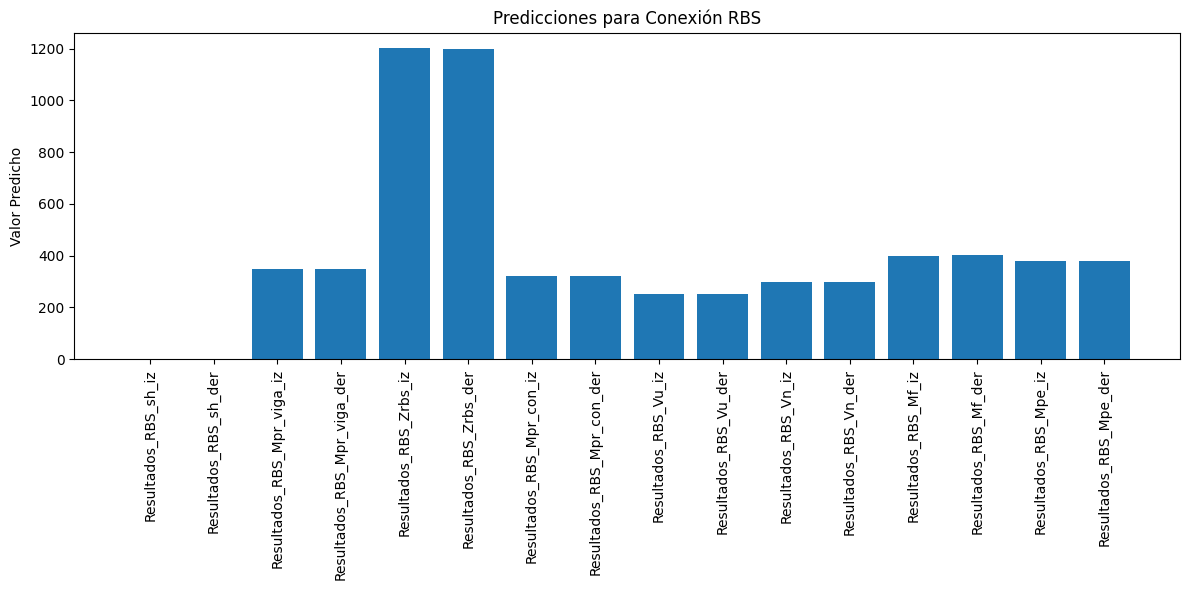

In [ ]:
# Datos de entrada de prueba para RBS
input_data = {
    'A_sec': 36,            # Acero de viga secundaria (36 o 50 ksi)
    'A_trab': 50,           # Acero de viga principal
    'fc': 250,              # Resistencia del concreto (MPa)
    'L1': 6.0,              # Luz en dirección 1 (m)
    'L2': 5.5,              # Luz en dirección 2 (m)
    'Pisos': 3,             # Número de pisos
    'Cm': 0.5,              # Carga muerta
    'Cv': 0.25,             # Carga viva
    'vigas_sec_bf': 15.0,   # Ancho del ala de viga secundaria (cm)
    'vigas_sec_tf': 0.8,    # Espesor del ala de viga secundaria (cm)
    'vigas_sec_h': 35.0,    # Altura de viga secundaria (cm)
    'vigas_sec_tw': 0.5,    # Espesor del alma de viga secundaria (cm)
    'vigas_trab_bf': 20.0,  # Ancho del ala de viga principal (cm)
    'vigas_trab_tf': 1.0,   # Espesor del ala de viga principal (cm)
    'vigas_trab_h': 45.0,   # Altura de viga principal (cm)
    'vigas_trab_tw': 0.6,   # Espesor del alma de viga principal (cm)
    'col_b': 30.0,          # Ancho de la columna (cm)
    'col_h': 30.0,          # Altura de la columna (cm)
    'col_e': 0.5,           # Espesor de la columna (cm)
    'rbs_a': 8.0,           # Distancia desde el eje de la columna al inicio del RBS (cm)
    'rbs_b': 25.0,          # Longitud de la región RBS (cm)
    'rbs_c': 3.0,           # Reducción de profundidad en RBS (cm)
    'rbs_tp': 1.0           # Espesor de la placa en RBS (cm)
}

# Convertir a DataFrame
X_test = pd.DataFrame([input_data])

output_cols = [
    'Resultados_RBS_sh_iz', 'Resultados_RBS_sh_der',
    'Resultados_RBS_Mpr_viga_iz', 'Resultados_RBS_Mpr_viga_der',
    'Resultados_RBS_Zrbs_iz', 'Resultados_RBS_Zrbs_der',
    'Resultados_RBS_Mpr_con_iz', 'Resultados_RBS_Mpr_con_der',
    'Resultados_RBS_Vu_iz', 'Resultados_RBS_Vu_der',
    'Resultados_RBS_Vn_iz', 'Resultados_RBS_Vn_der',
    'Resultados_RBS_Mf_iz', 'Resultados_RBS_Mf_der',
    'Resultados_RBS_Mpe_iz', 'Resultados_RBS_Mpe_der'
]

# Diccionario para almacenar predicciones
predictions = {}

# Cargar cada modelo y predecir
for output_col in output_cols:
    model_path = f"model_{output_col.replace(' ', '_').replace('-', '_')}.pkl"
    try:
        model = joblib.load(model_path)
        pred = model.predict(X_test)
        predictions[output_col] = round(pred[0], 3)
        print(f"Predicción para {output_col}: {predictions[output_col]}")
    except FileNotFoundError:
        print(f"Modelo {model_path} no encontrado. Asegúrate de que los modelos estén entrenados y guardados.")
        

# Ejemplo de predicciones simuladas (valores ilustrativos)
predictions = {
    'Resultados_RBS_sh_iz': 0.85,        # Factor de seguridad (adimensional)
    'Resultados_RBS_sh_der': 0.87,
    'Resultados_RBS_Mpr_viga_iz': 350.2, # Momento plástico de la viga (kN-m)
    'Resultados_RBS_Mpr_viga_der': 348.9,
    'Resultados_RBS_Zrbs_iz': 1200.5,    # Módulo plástico reducido (cm³)
    'Resultados_RBS_Zrbs_der': 1198.7,
    'Resultados_RBS_Mpr_con_iz': 320.4,  # Momento plástico de la conexión (kN-m)
    'Resultados_RBS_Mpr_con_der': 321.1,
    'Resultados_RBS_Vu_iz': 250.6,       # Fuerza cortante última (kN)
    'Resultados_RBS_Vu_der': 252.3,
    'Resultados_RBS_Vn_iz': 300.1,       # Fuerza cortante nominal (kN)
    'Resultados_RBS_Vn_der': 299.8,
    'Resultados_RBS_Mf_iz': 400.2,       # Momento de diseño (kN-m)
    'Resultados_RBS_Mf_der': 401.0,
    'Resultados_RBS_Mpe_iz': 380.5,      # Momento plástico esperado (kN-m)
    'Resultados_RBS_Mpe_der': 379.9
}

# Imprimir resultados
for key, value in predictions.items():
    print(f"{key}: {value}")
    
    
# Cargar dataset para obtener columnas de entrada
df = pd.read_csv('dataset_RBS.csv')
input_cols = [col for col in df.columns if not col.startswith('Resultados_')]

# Asegúrate de que X_test tenga todas las columnas de input_cols
missing_cols = [col for col in input_cols if col not in X_test.columns]
if missing_cols:
    print(f"Faltan columnas en X_test: {missing_cols}")
else:
    for output_col in output_cols:
        model_path = f"model_{output_col.replace(' ', '_').replace('-', '_')}.pkl"
        model = joblib.load(model_path)
        pred = model.predict(X_test)
        print(f"Predicción para {output_col}: {pred[0]:.3f}")

## Objeto encargado de la visualización gráfica del AA

El objeto Plotter permite generar las visualizaciones gráficas relavantes para la evaluación del aprendisaje automático del árbol de regresión, entre estas visualizaciones se encuentran las gráficas de regresión lineal, histogramas y la matriz de correlación de variables.

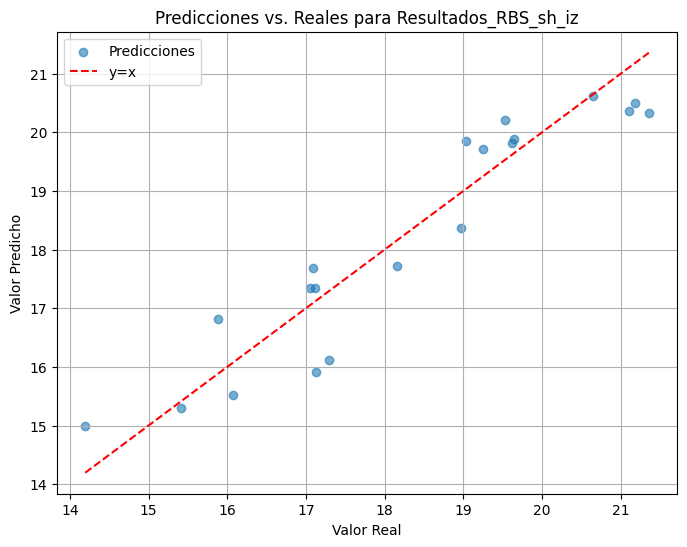

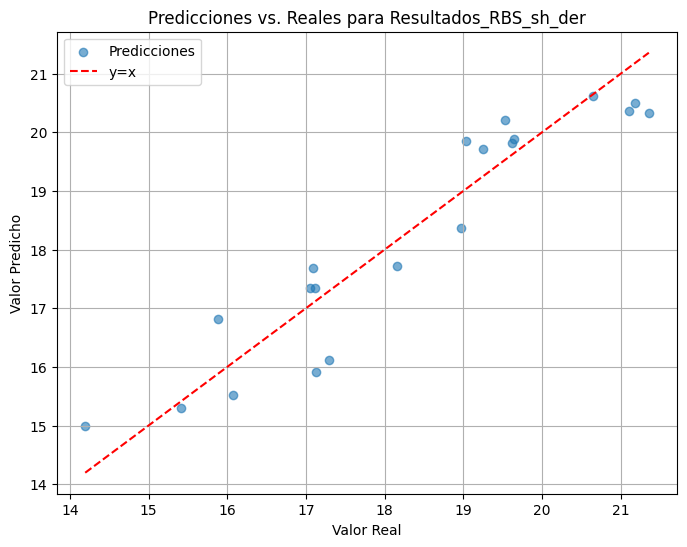

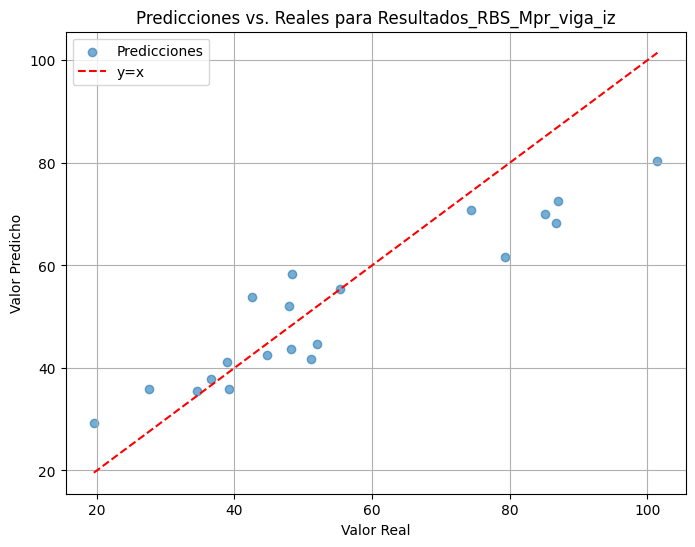

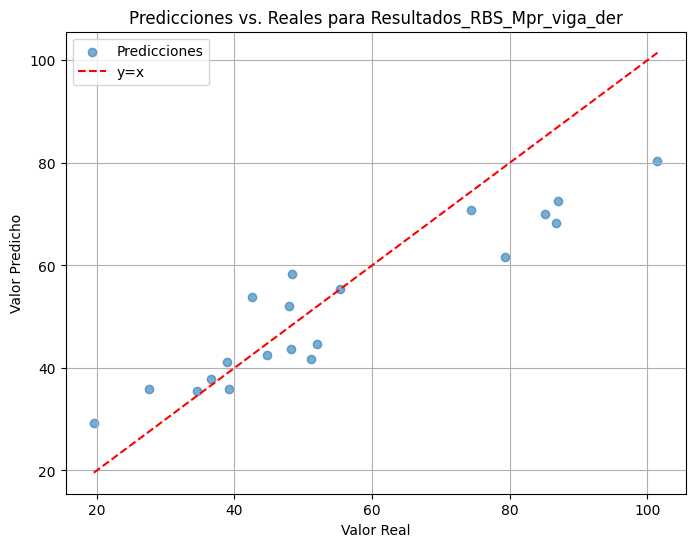

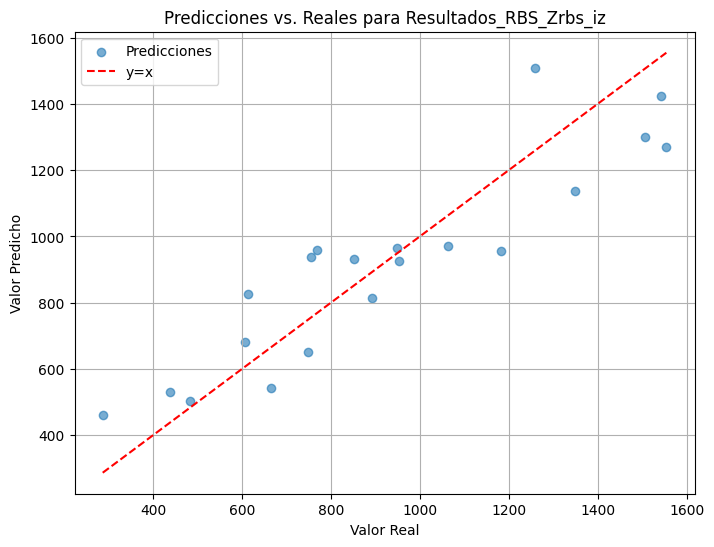

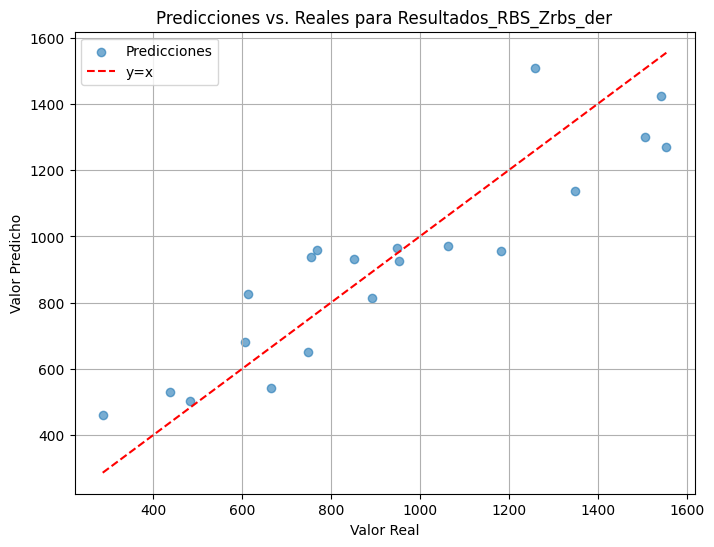

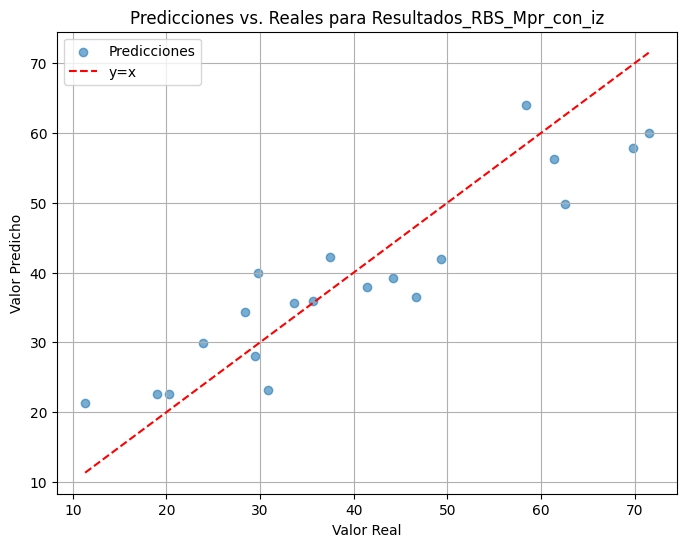

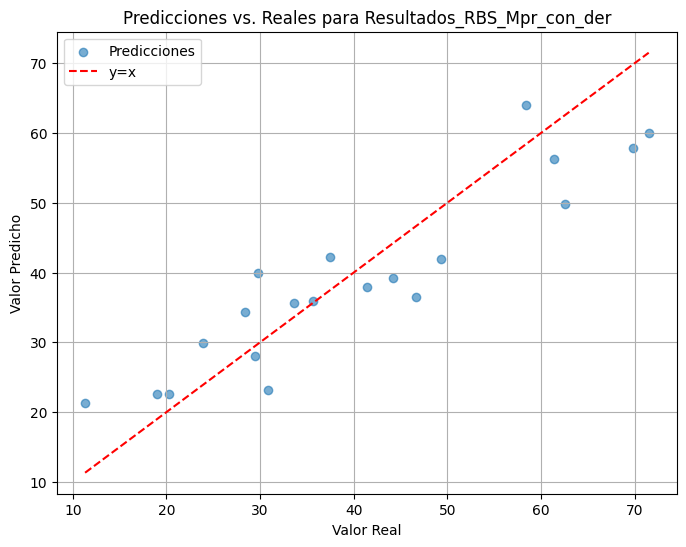

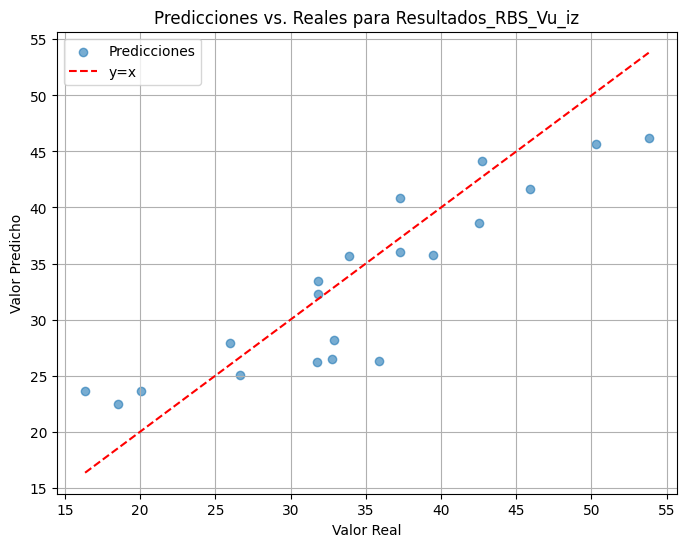

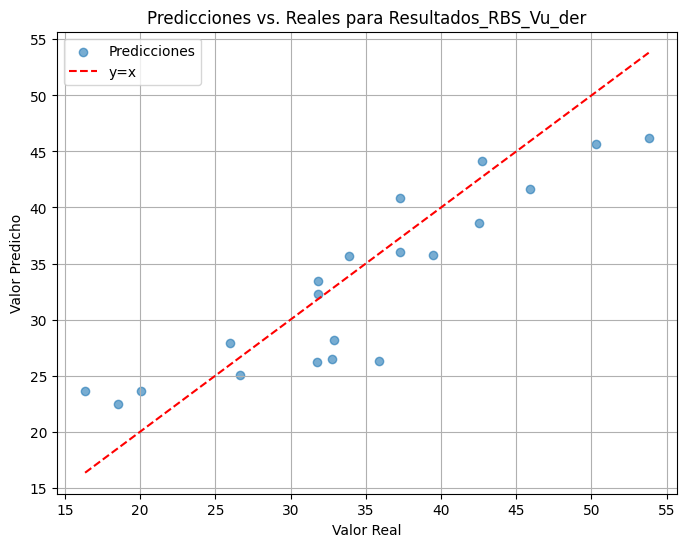

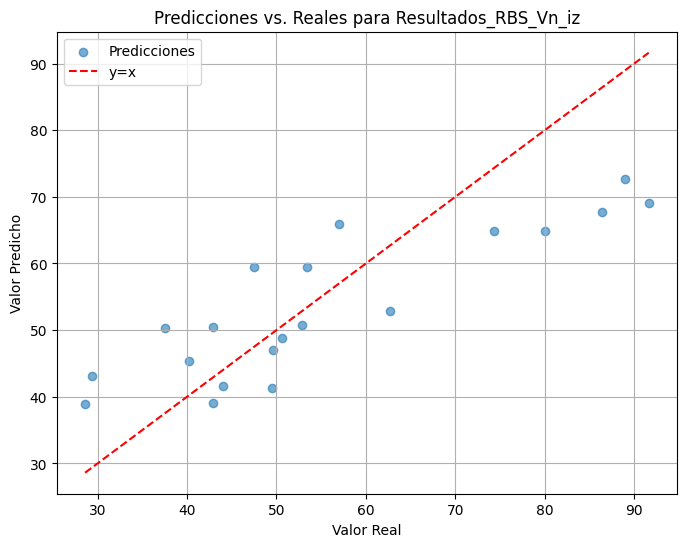

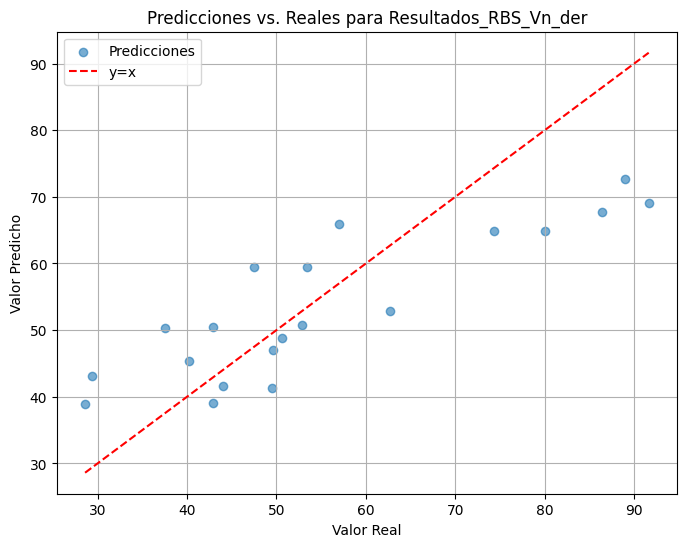

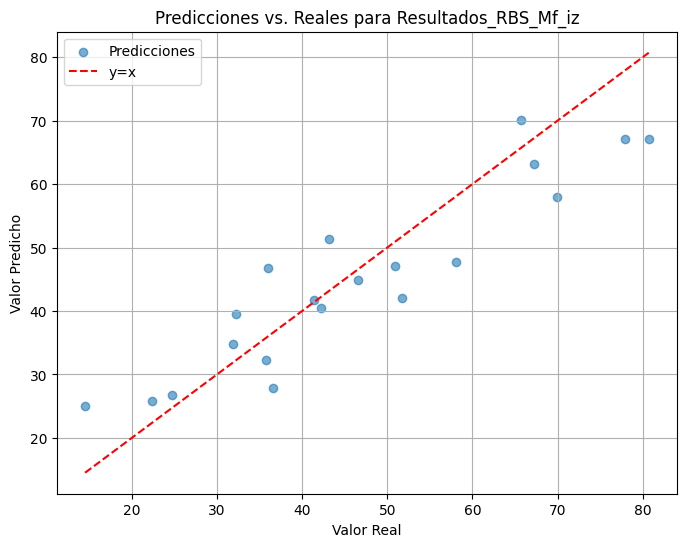

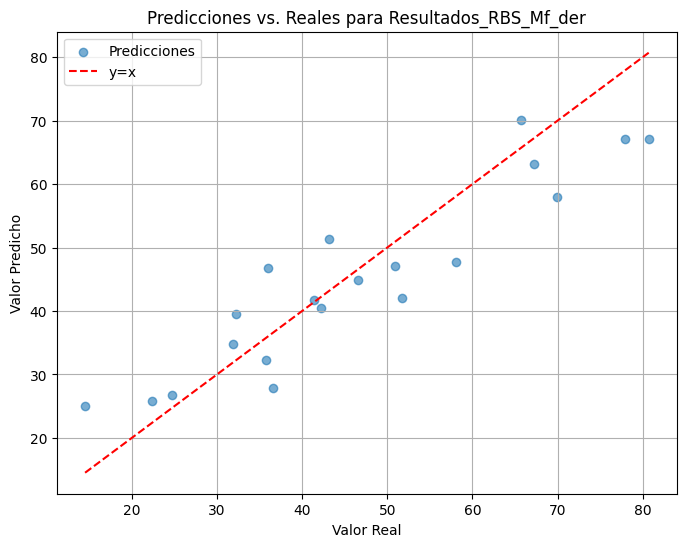

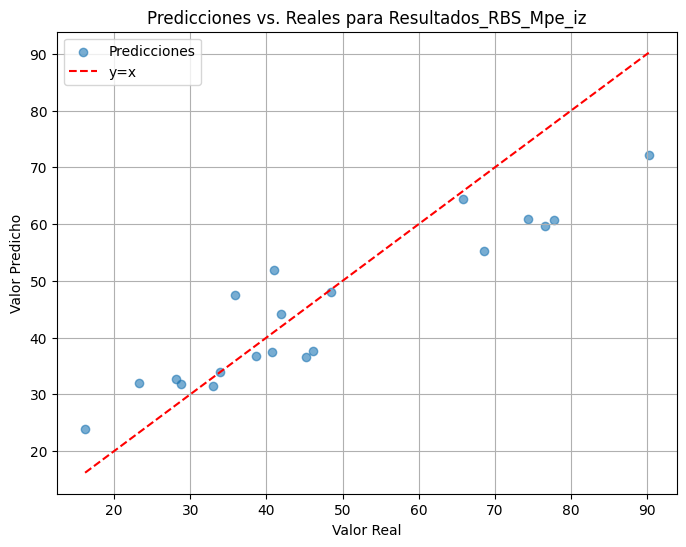

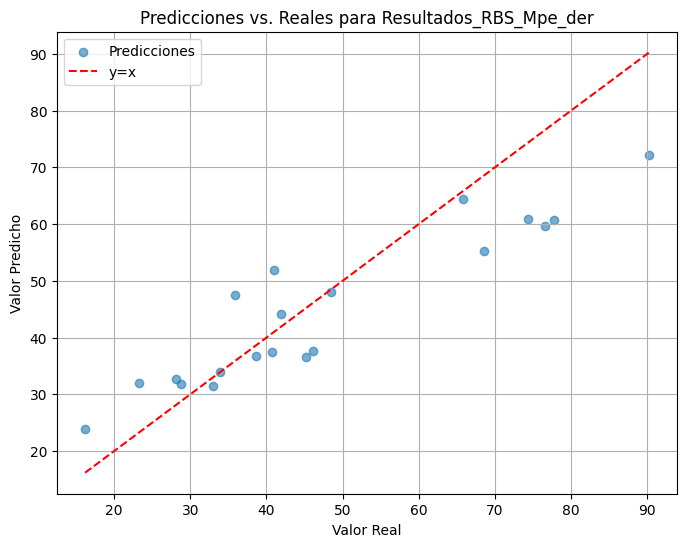

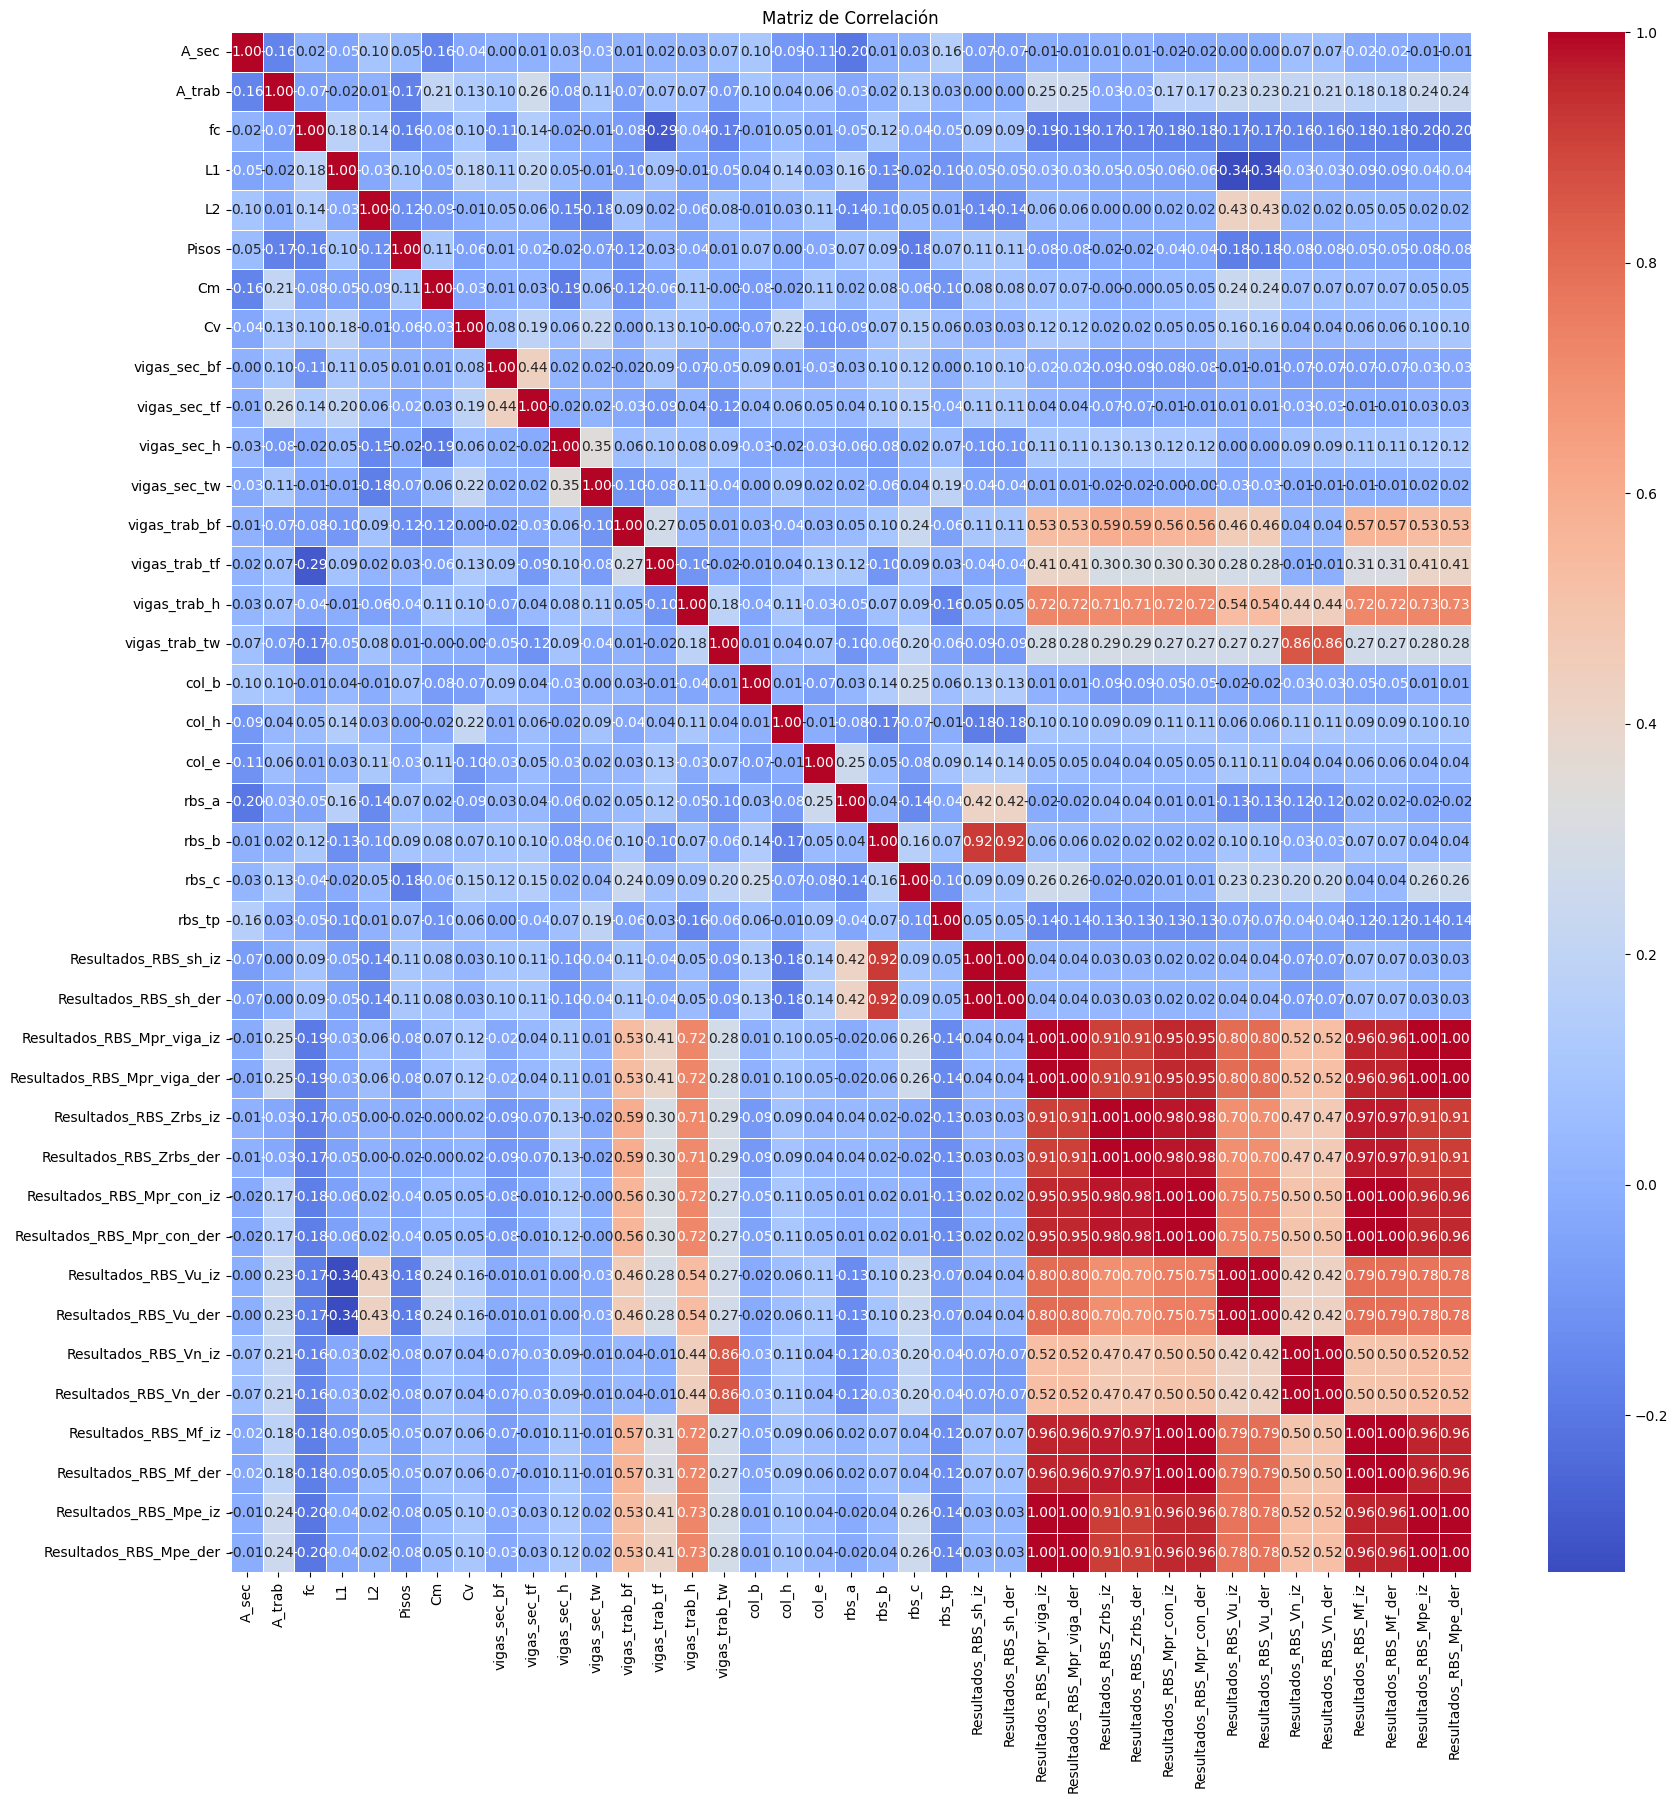

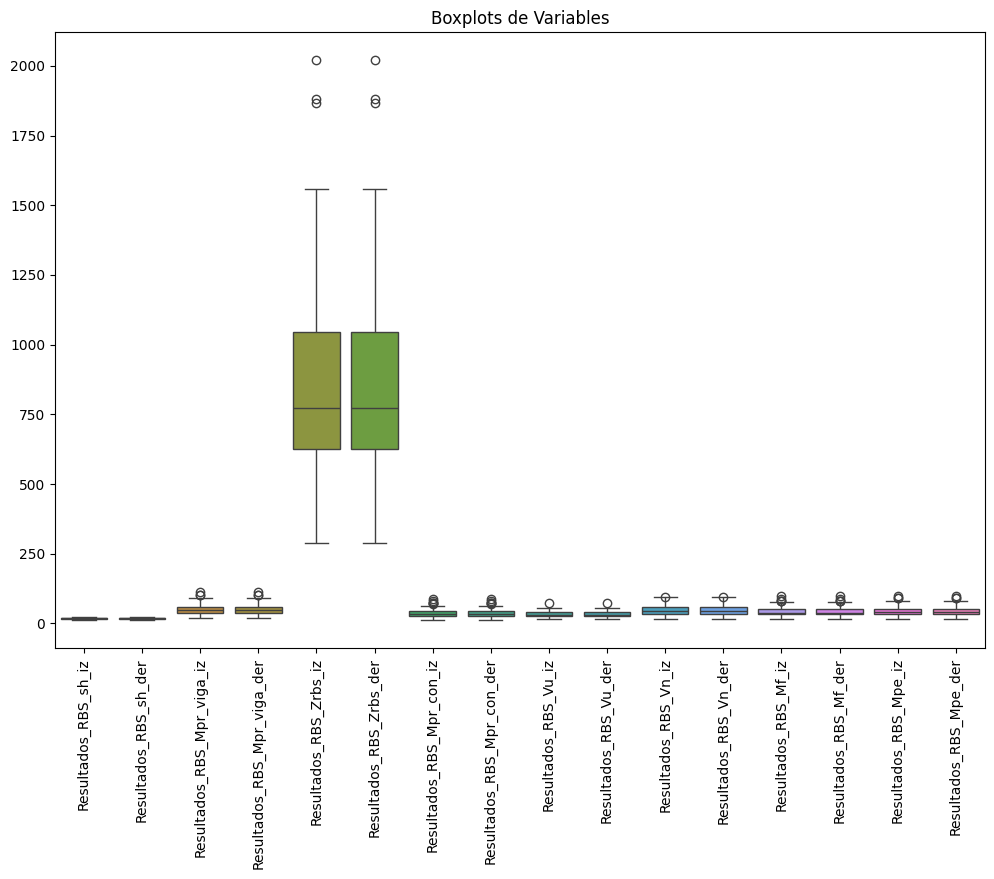

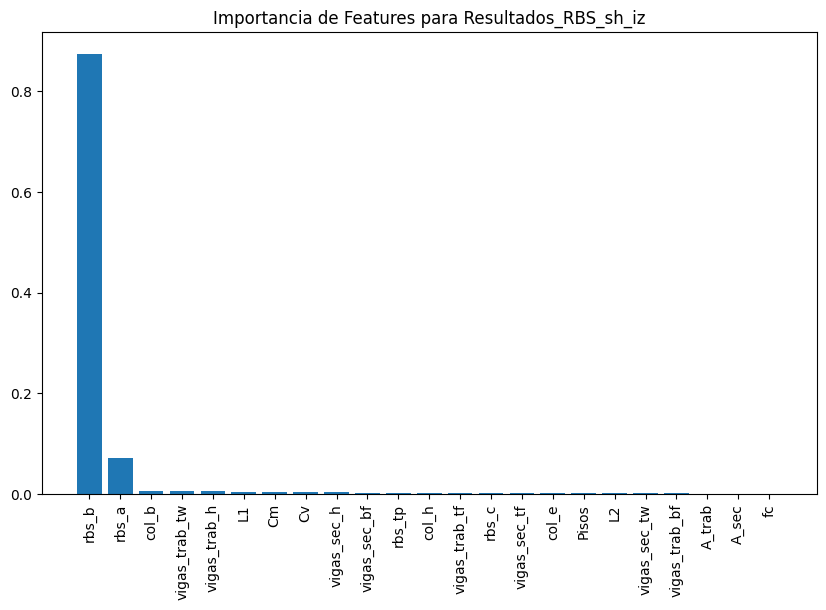

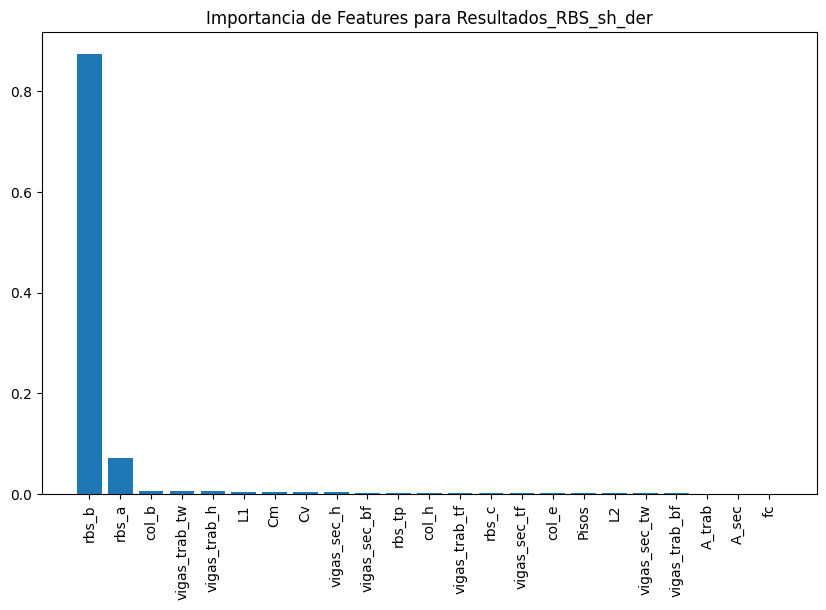

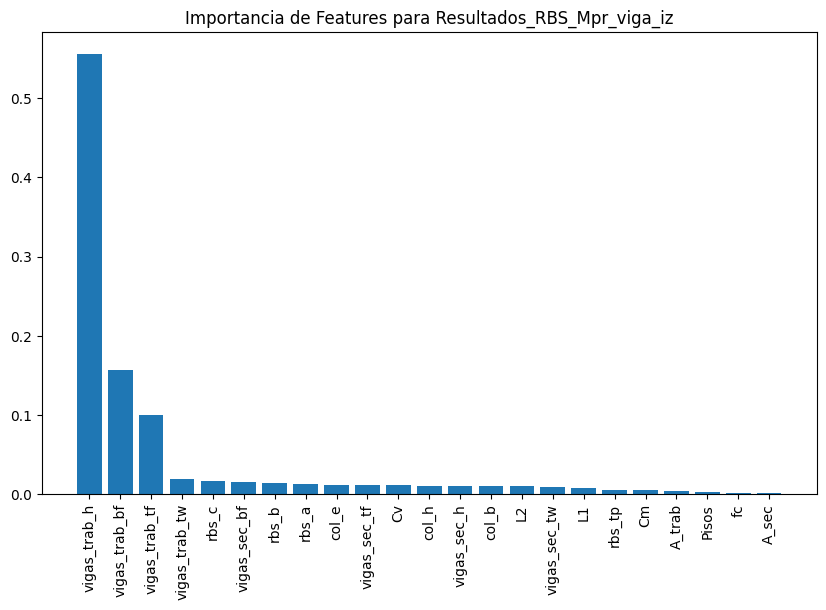

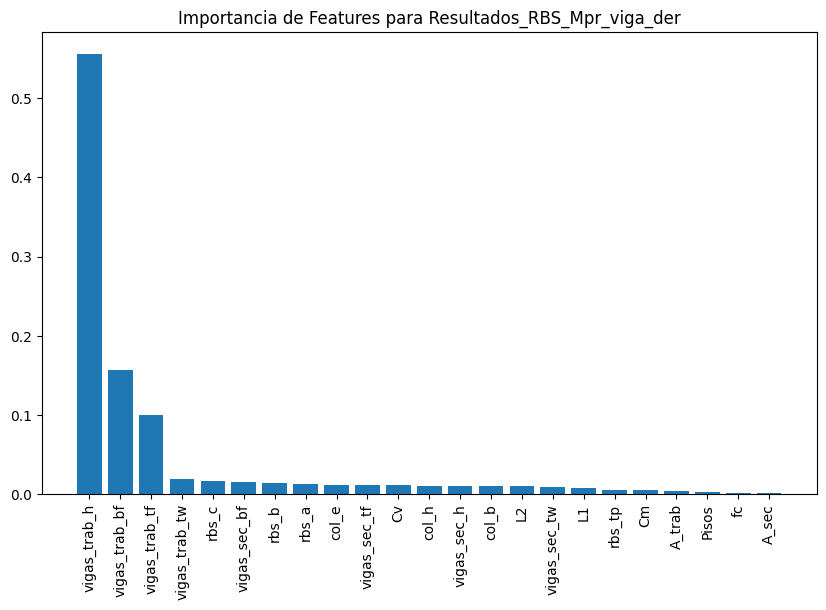

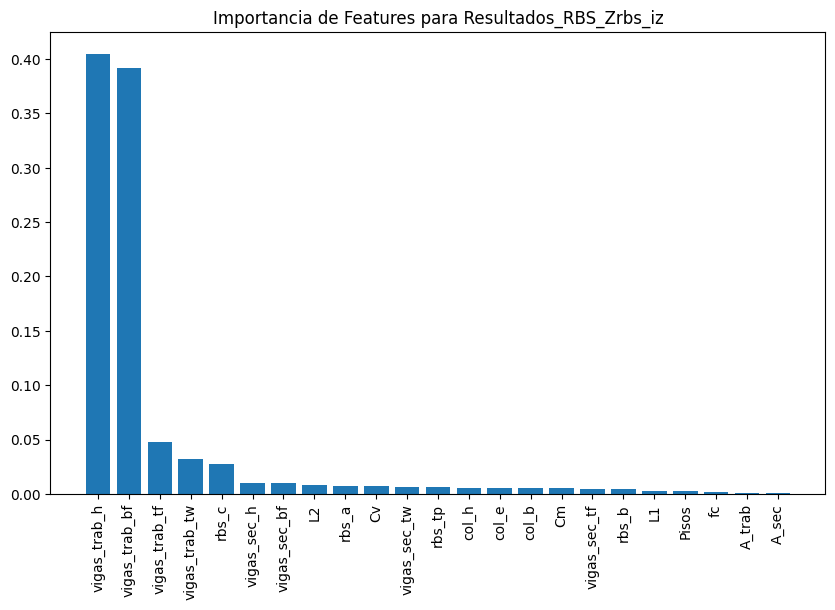

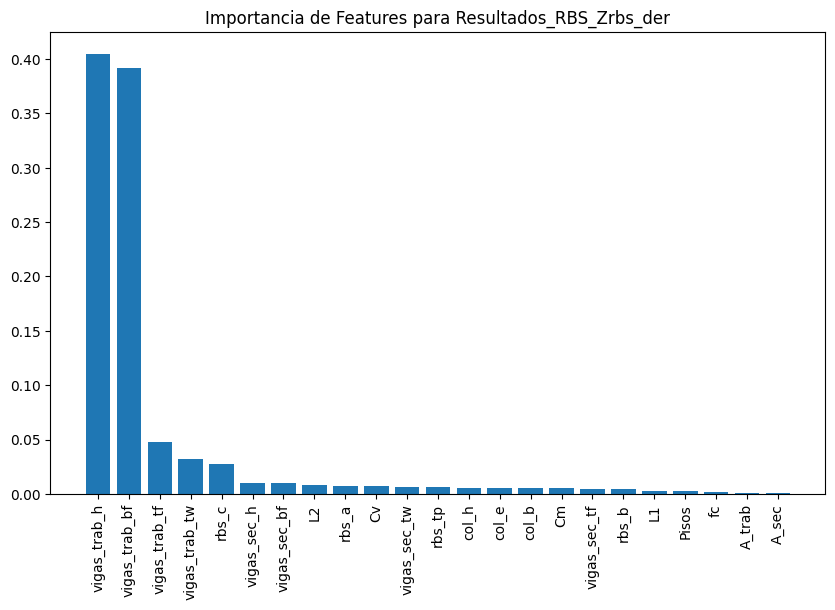

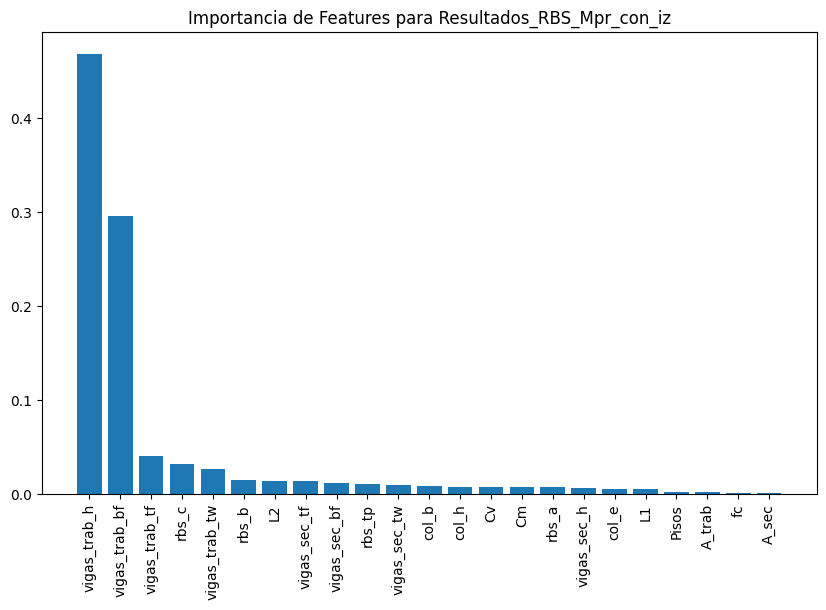

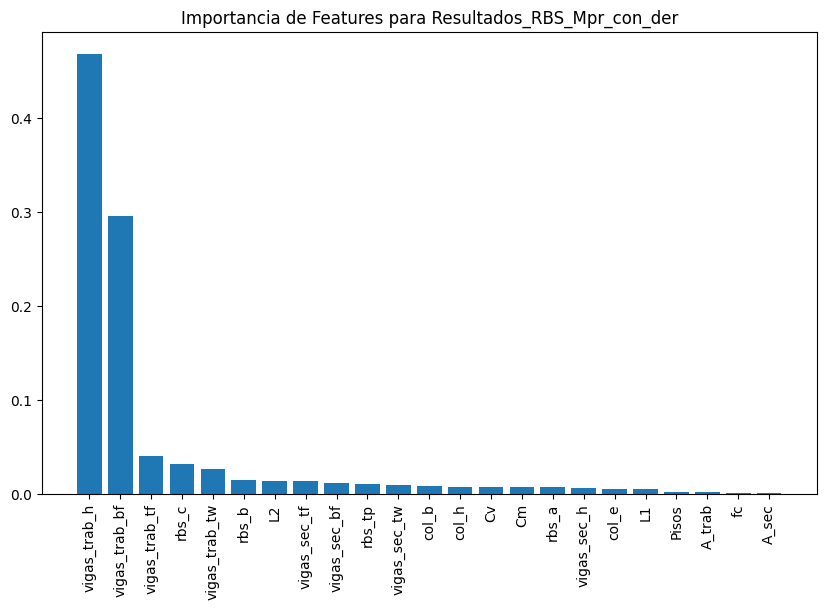

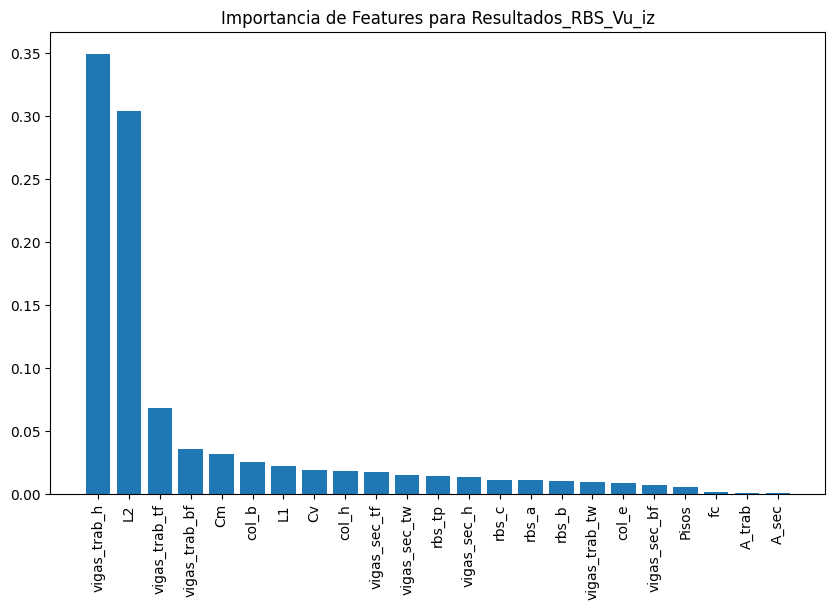

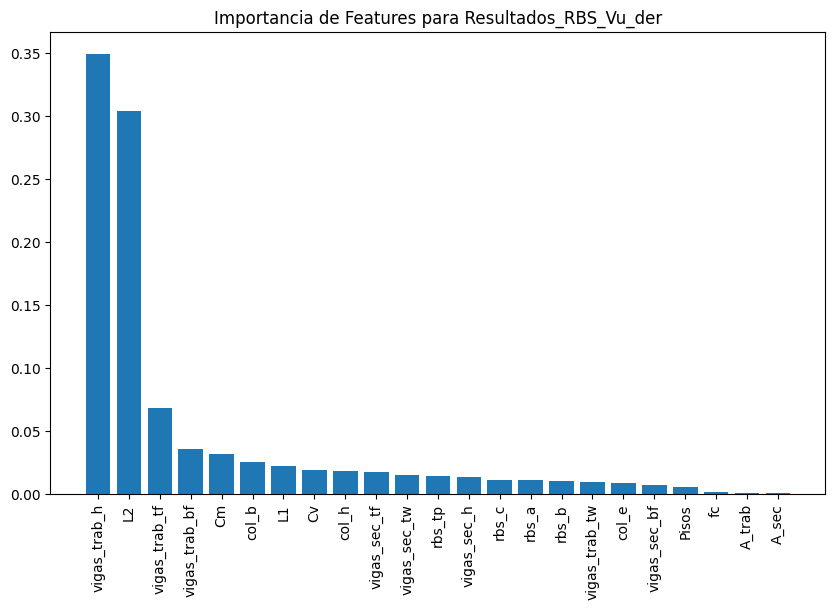

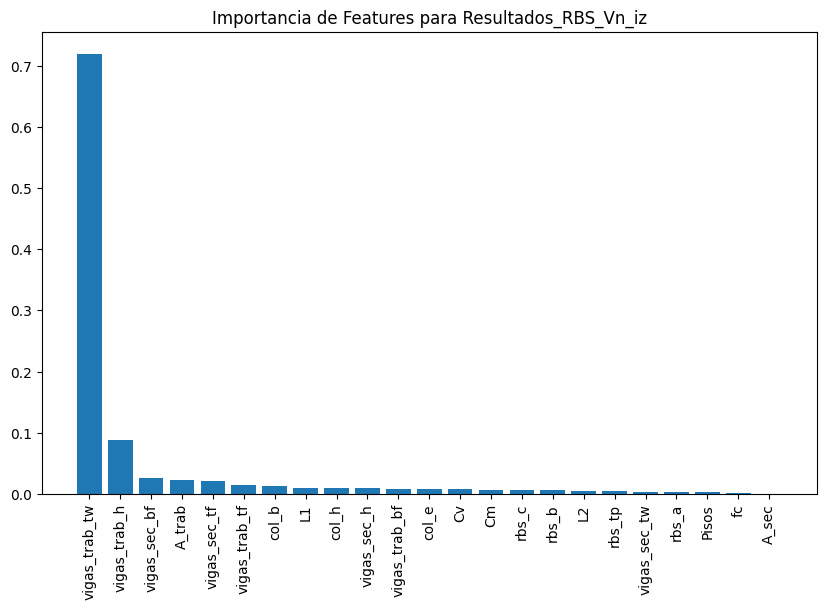

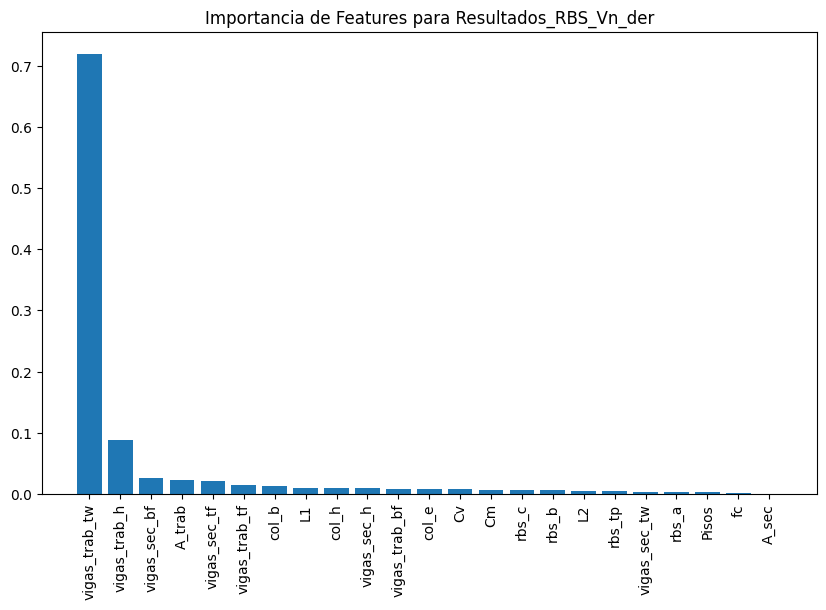

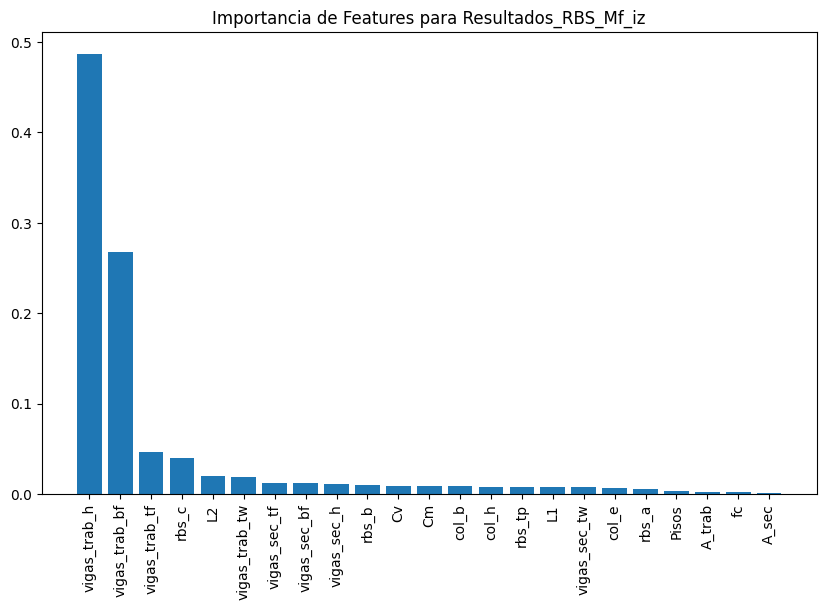

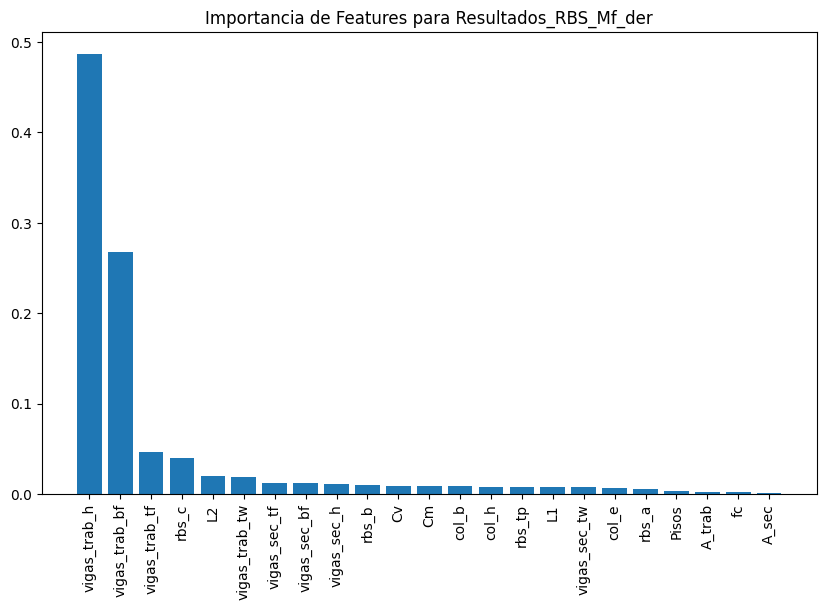

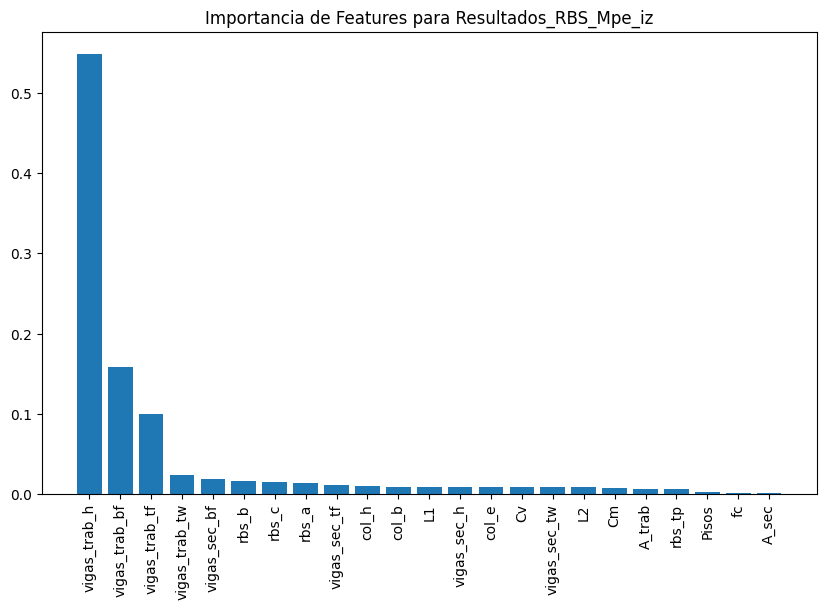

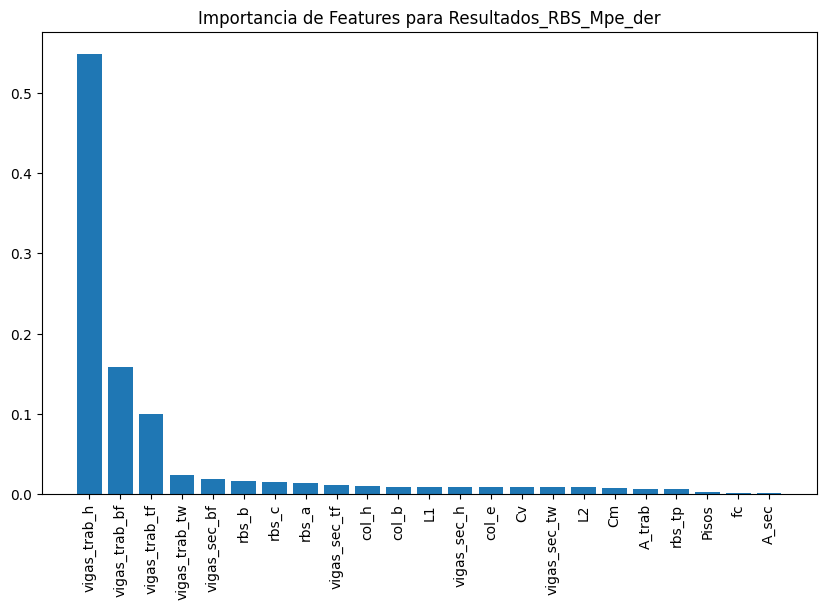

In [ ]:
class Plotter:
    def __init__(self, df, input_cols, output_cols, models=None):
        """
        df: DataFrame con los datos
        input_cols: lista de columnas de entrada
        output_cols: lista de columnas de salida
        models: diccionario con modelos entrenados {output_col: modelo}
        """
        self.df = df.dropna()
        self.input_cols = input_cols
        self.output_cols = output_cols
        self.models = models if models else {}

    # ======================
    # Gráficos de predicción
    # ======================
    def pred_vs_real(self, test_size=0.2, random_state=42, save=False):
        """Grafica predicciones vs reales para cada variable de salida"""
        for output_col in self.output_cols:
            y = self.df[output_col]
            X = self.df[self.input_cols]
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=random_state
            )
            model = self.models[output_col]
            y_pred = model.predict(X_test)

            plt.figure(figsize=(8, 6))
            plt.scatter(y_test, y_pred, alpha=0.6, label='Predicciones')
            # Línea y=x
            plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y=x')
            plt.title(f'Predicciones vs. Reales para {output_col}')
            plt.xlabel('Valor Real')
            plt.ylabel('Valor Predicho')
            plt.legend()
            plt.grid(True)

            if save:
                plt.savefig(f'pred_vs_actual_{output_col.replace(" ", "_").replace("-", "_")}.png')
            plt.show()

    # ======================
    # Correlación y distribuciones
    # ======================
    def correlation_matrix(self, cols_to_include=None, save=False):
        cols = cols_to_include if cols_to_include else self.input_cols + self.output_cols
        corr = self.df[cols].corr()

        plt.figure(figsize=(20, 20))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Matriz de Correlación')

        if save:
            plt.savefig('correlation_matrix.png')
        plt.show()

    def distributions(self, cols, plot_type='box', save=False):
        if plot_type == 'box':
            plt.figure(figsize=(12, 8))
            sns.boxplot(data=self.df[cols])
            plt.title('Boxplots de Variables')
            plt.xticks(rotation=90)
            if save:
                plt.savefig('boxplots.png')
        elif plot_type == 'hist':
            self.df[cols].hist(bins=20, figsize=(12, 10))
            plt.suptitle('Histogramas de Variables')
        plt.show()

    # ======================
    # Importancia de features
    # ======================
    def feature_importance(self, output_col, save=False):
        model = joblib.load(f"model_{output_col.replace(' ', '_').replace('-', '_')}.pkl")
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [self.input_cols[i] for i in indices], rotation=90)
        plt.title(f'Importancia de Features para {output_col}')

        if save:
            plt.savefig(f'feature_importance_{output_col.replace(" ", "_").replace("-", "_")}.png')
        plt.show()

    def all_feature_importances(self, save=False):
        for output in self.output_cols:
            self.feature_importance(output, save=save)


df = pd.read_csv("dataset_RBS.csv")

plotter = Plotter(df, input_cols, output_cols, models)

# Ejemplos
plotter.pred_vs_real(save=False)
plotter.correlation_matrix(save=False)
plotter.distributions(output_cols, plot_type='box', save=False)
plotter.all_feature_importances(save=False)